In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import random
from torch_geometric.data import Data

In [2]:
os.chdir('/public/home/jijh/diffusion_project/ADiffusion')

In [3]:
import importlib
import src.preprocessing.data_process
importlib.reload(src.preprocessing.data_process)

<module 'src.preprocessing.data_process' from '/public/home/jijh/diffusion_project/ADiffusion/src/preprocessing/data_process.py'>

In [4]:
from src.preprocessing.data_process import extract_patches, create_graph_data_dict, construct_affinity_matrix

In [5]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preprocessing

In [6]:
from tqdm import tqdm

file_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in tqdm(adatas.keys(), desc="Preprocessing datasets"):
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    adatas[key].layers["raw"] = adatas[key].X.copy()  # Store the raw data in the "raw" layer
    sc.pp.scale(adatas[key])  # Scale the data to unit variance
    sc.tl.pca(adatas[key], svd_solver="arpack")  # Perform PCA

Preprocessing datasets: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


In [7]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()

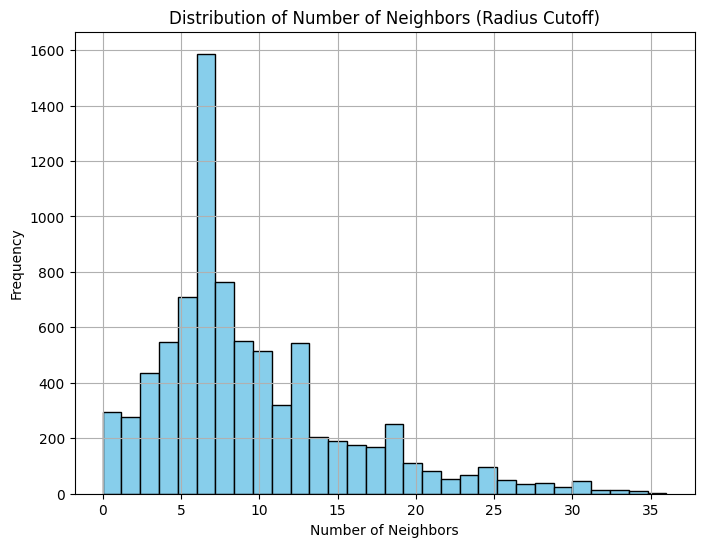

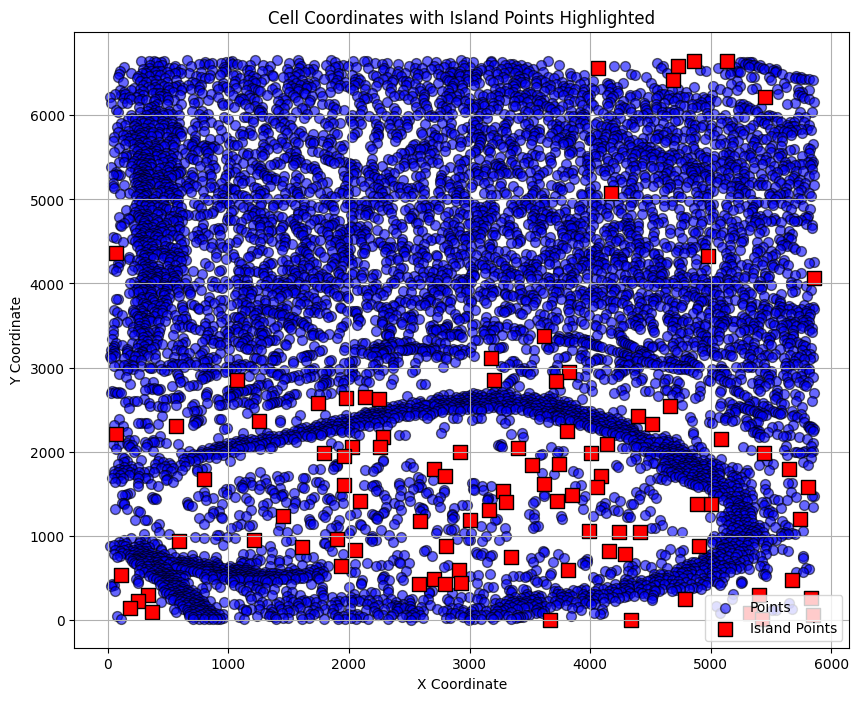

Number of island points: 95
Island point indices: [  10   14   75  116  297  570 2185 3146 3190 3556 4577 4952 5158 5247
 5253 5262 5431 5449 5461 5536 5596 5768 5861 5893 5913 5981 6022 6053
 6068 6128 6156 6162 6173 6224 6227 6229 6239 6256 6328 6333 6387 6389
 6445 6456 6479 6527 6540 6559 6561 6591 6620 6675 6676 6684 6698 6702
 6744 6794 6815 6825 6832 6894 6899 6901 6947 6963 6975 7005 7006 7014
 7036 7050 7078 7122 7249 7348 7349 7462 7573 7579 7616 7637 7639 7790
 7792 7836 7853 7893 7998 8055 8072 8110 8174 8179 8181]


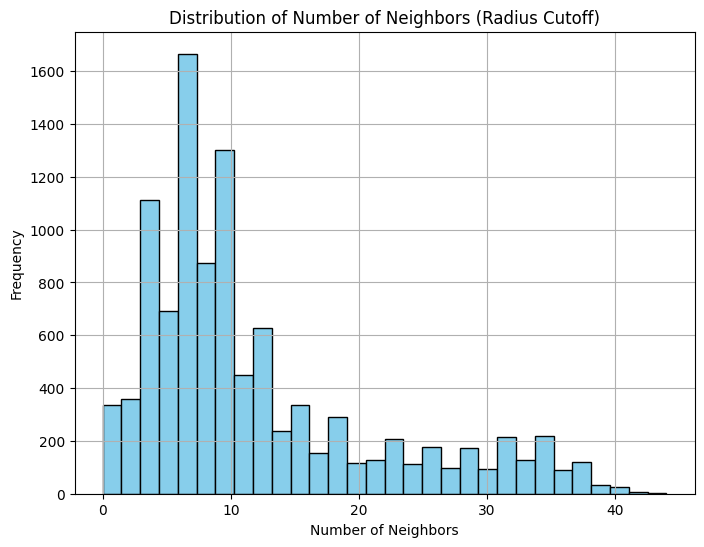

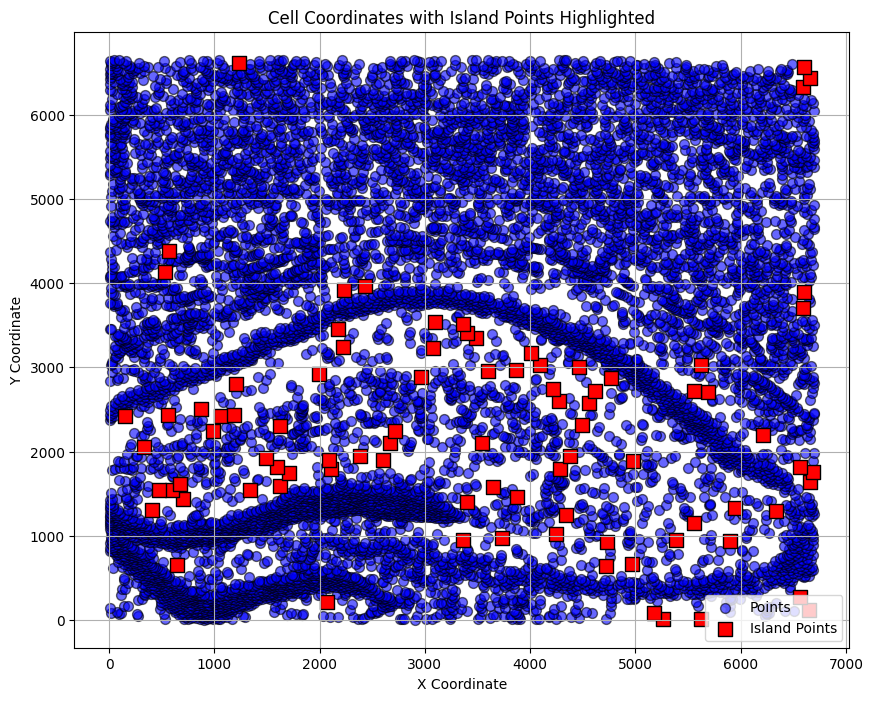

Number of island points: 88
Island point indices: [   10    24   121   161   321   434  1366  1377  1386  1768  1794  1809
  1821  1878  1959  2211  2405  2548  2593  2680  2841  2910  2966  3110
  3116  3118  3161  3166  3186  3209  3298  3306  3335  3336  3362  3363
  3413  3423  3425  3438  3464  3474  3565  3598  3604  3691  3730  3739
  3799  3807  3940  3941  3947  3958  4017  4101  4132  4258  4266  4271
  4310  4381  4437  4462  4504  4544  4549  4580  4609  4639  4785  4848
  4872  5023  5122  5195  5278  5323  5574  5937  5961  6020  6253  6683
  9863 10026 10233 10310]


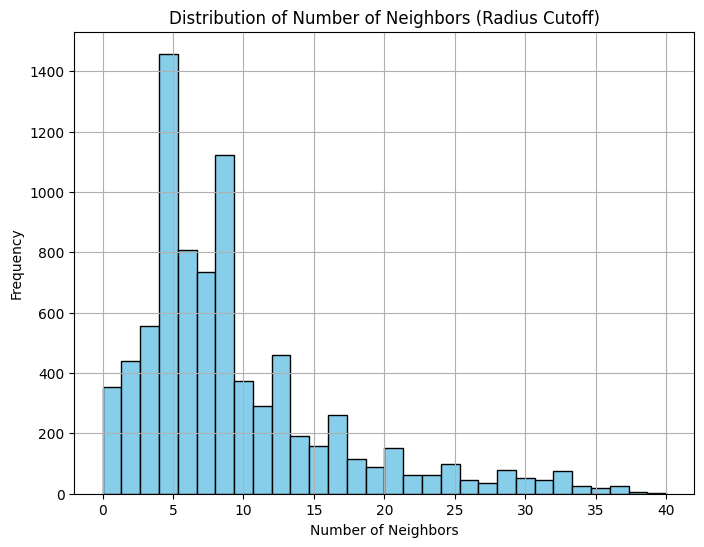

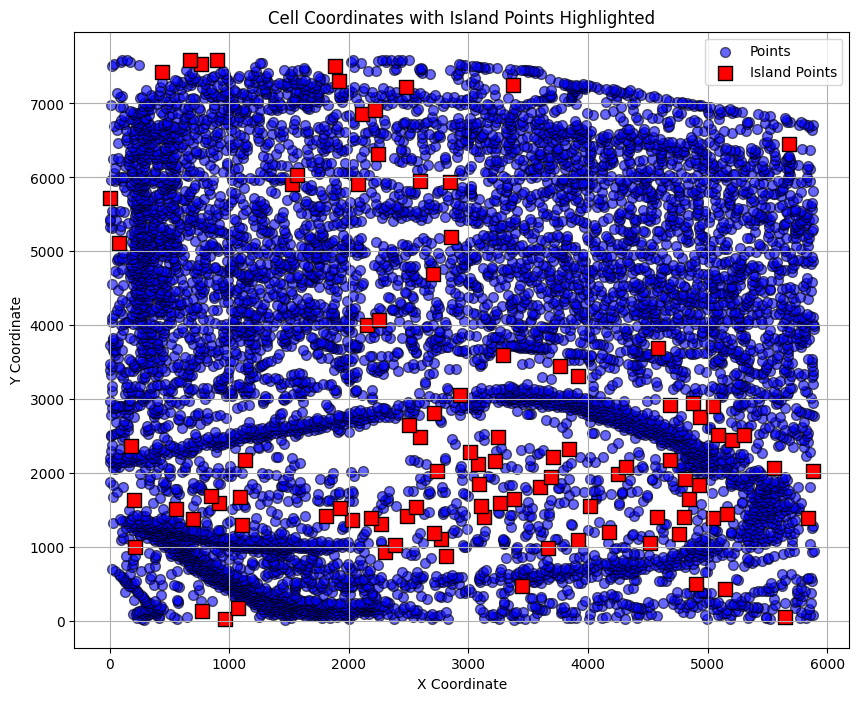

Number of island points: 100
Island point indices: [  18   43  155  239  601  632  672 1165 1215 1289 1313 1374 1426 1502
 1517 1595 1618 1637 1747 1766 1809 1811 1821 1823 1824 1828 1830 1831
 1840 1842 1856 1896 1904 1914 1915 1924 1940 1943 1966 1974 1976 1989
 1994 2085 2106 2126 2165 2177 2197 2222 2224 2249 2259 2292 2328 2332
 2335 2372 2409 2440 2474 2526 2557 2558 2588 2593 2739 2862 2909 3024
 3053 3081 3232 3454 3556 3716 3821 4207 4287 5122 5669 5764 6377 6569
 6575 6619 6632 6732 7035 7199 7678 7710 8032 8043 8083 8133 8172 8180
 8194 8201]


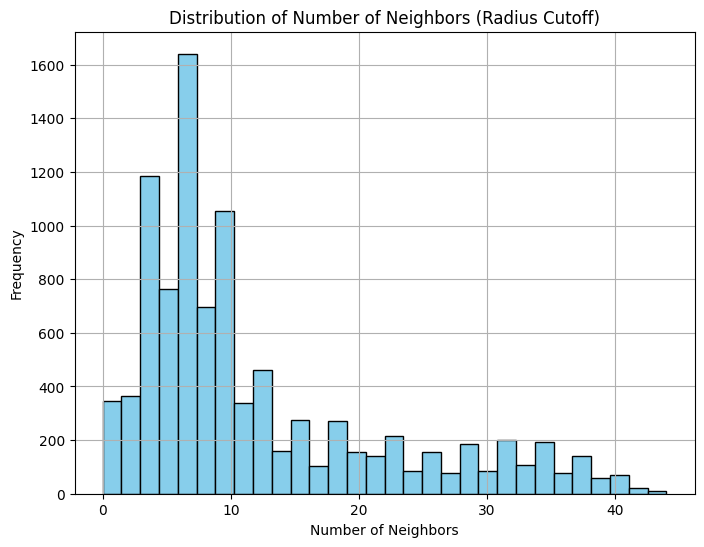

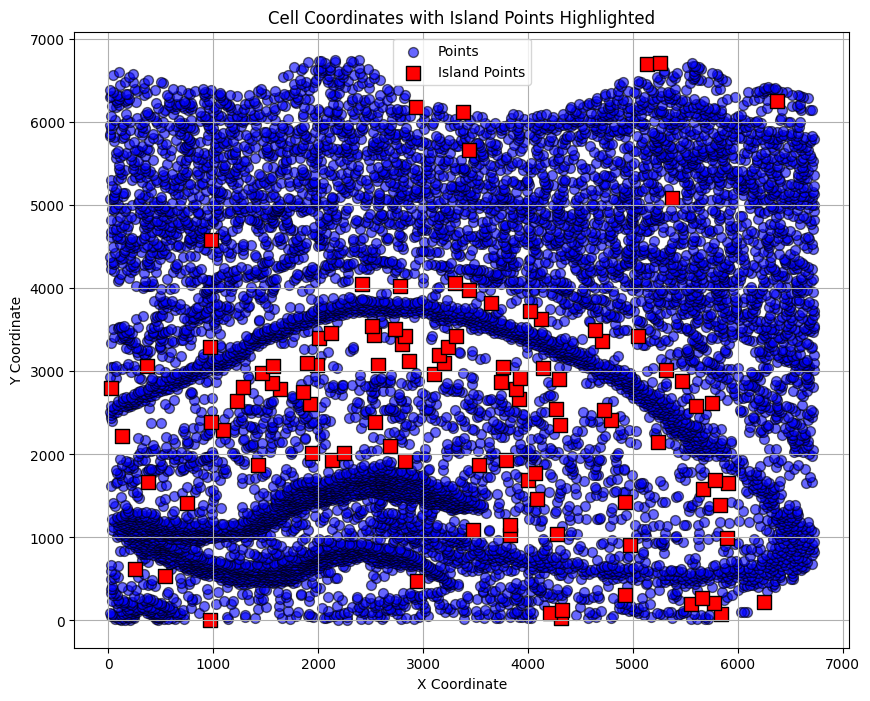

Number of island points: 102
Island point indices: [   2   32  116  137  195  270  275  282  350  380  536  649  871 1703
 1856 1922 1962 2065 2232 2638 2682 2694 2755 3028 3186 3208 3268 3272
 3403 3505 3506 3546 3549 3555 3620 3631 3708 3751 3815 3878 3950 3974
 3985 4000 4133 4154 4187 4212 4220 4241 4285 4360 4387 4397 4416 4423
 4469 4489 4505 4537 4565 4600 4613 4645 4670 4690 4708 4715 4718 4719
 4734 4741 4759 4835 4939 4947 4972 5008 5062 5096 5101 5107 5109 5157
 5203 5238 5286 5393 5583 5799 5982 6026 6062 6080 6839 7639 8517 9231
 9305 9384 9623 9624]


In [8]:
neighbors = {}
for key in cell_coords.keys():
    neighbors[key] = construct_affinity_matrix(cell_coords[key], mode='radius', cutoff=100)

In [9]:

# Load the plaque dataset
img_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)



In [10]:
# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


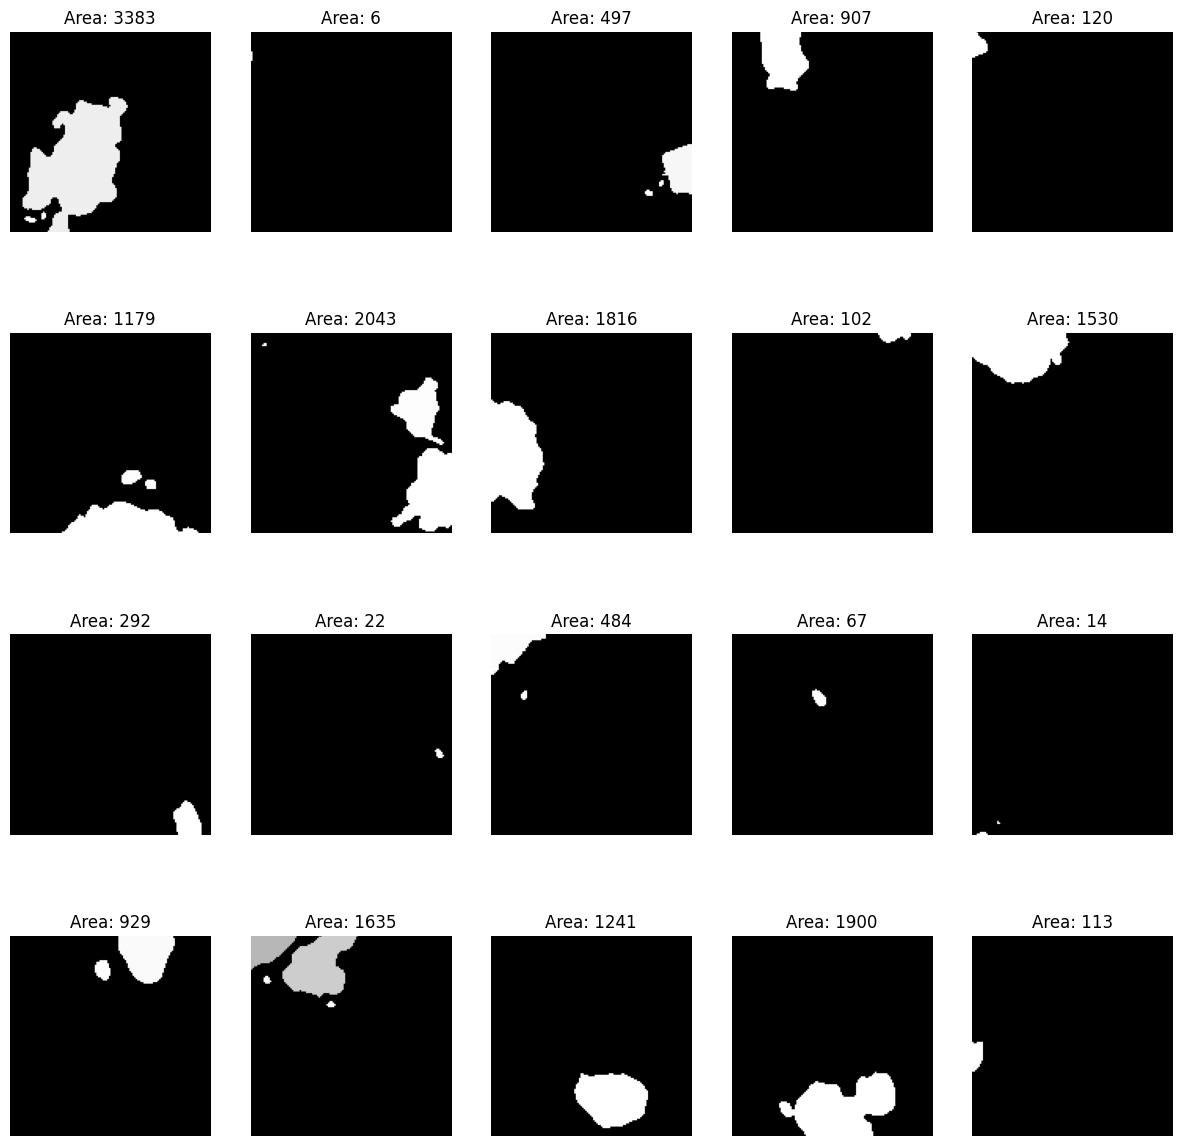

In [11]:
# Choose 5 patches with non-zero area for each image and plot them
import matplotlib.pyplot as plt

# Set the number of patches to plot
n_patches = 5

# Plot the patches
fig, axes = plt.subplots(nrows=len(areas), ncols=n_patches, figsize=(15, 15))
axes = np.atleast_2d(axes)  # Ensure axes is 2D for consistent indexing

for i, key in enumerate(areas.keys()):
    non_zero_indices = np.where(np.array(areas[key]) > 0)[0]
    chosen_indices = random.sample(list(non_zero_indices), n_patches)
    for j, idx in enumerate(chosen_indices):
        axes[i, j].imshow(patches[key][idx], cmap="gray")
        axes[i, j].set_title(f"Area: {areas[key][idx]}")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(key, rotation=0, size="large", labelpad=50)

In [12]:
# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords, embeddings=["X"])


# Efficiently convert patches to tensors in batch
for key, graph in tqdm(graph_data_dict.items(), desc="Adding patches to graph data"):
    # Ensure patches[key] is a list of NumPy arrays
    patches_tensor = torch.tensor(np.array(patches[key]), dtype=torch.float)  # Convert patches to a single tensor efficiently
    graph.patches = patches_tensor

Adding patches to graph data: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


{'8months-disease-replicate_1': Data(x=[8186, 50], edge_index=[2, 76592], edge_attr=[76592, 1], y=[8186, 1], pos=[8186, 2], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 50], edge_index=[2, 123704], edge_attr=[123704, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 50], edge_index=[2, 75568], edge_attr=[75568, 1], y=[8202, 1], pos=[8202, 2], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 50], edge_index=[2, 115726], edge_attr=[115726, 1], y=[9634, 1], pos=[9634, 2], patches=[9634, 128, 128, 1])}

# Prediction & Represenation of the graph

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool


In [14]:
test_replicate_name = '13months-disease-replicate_2'


In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    data.y = (data.y > 0).float()  # Binarize

    if name == test_replicate_name:
        # This entire graph is our final test set.
        test_data = data
    else:
        # We do random node-level splits for training & validation
        num_nodes = data.x.size(0)
        perm = torch.randperm(num_nodes)

        train_cutoff = int(0.8 * num_nodes)
        val_cutoff   = int(0.9 * num_nodes)

        data.train_idx = perm[:train_cutoff]
        data.val_idx   = perm[train_cutoff:val_cutoff]
        data.mini_test_idx = perm[val_cutoff:]  # optional mini-test

        train_val_datalist.append(data)

# Move test_data to device
test_data = test_data.to(device)


In [78]:
class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, residual=True, dropout=0.5):
        super().__init__()
        
        # -- GCN Layer --
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        # -- GraphSAGE Layer --
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        # Optional skip connection parameter
        self.residual = residual

        # -- Final MLP block --
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None, edge_weight=None):
        # --- First layer: GCN ---
        out1 = self.conv1(x, edge_index, edge_weight)
        out1 = self.bn1(out1)
        out1 = F.relu(out1)
        out1 = self.dropout(out1)
        
        # --- Second layer: GraphSAGE ---
        out2 = self.conv2(out1, edge_index)
        out2 = self.bn2(out2)
        out2 = F.relu(out2)
        out2 = self.dropout(out2)
        
        # --- Residual Connection (optional) ---
        if self.residual:
            out2 = out1 + out2  # Skip connection

        # If graph-level classification, you'd pool here:
        #   out2 = global_mean_pool(out2, batch)
        # But for node-level, we skip global pooling.

        # --- Final MLP (per node) ---
        out = self.mlp(out2)

        return out


In [79]:
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


criterion = nn.BCEWithLogitsLoss()

def train_classifier(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr).squeeze()  # shape: [num_nodes]
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    return total_loss / len(datalist)


@torch.no_grad()
def evaluate_classifier(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Return average (loss, accuracy, AUC) across all graphs.
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_nodes   = 0
    all_labels    = []
    all_scores    = []
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()
        
        idx = getattr(data, split)  # e.g. data.val_idx
        labels = data.y[idx].view(-1)
        preds  = out[idx]
        
        # BCEWithLogitsLoss
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        # Accuracy
        prob = torch.sigmoid(preds)
        binary_pred = (prob > 0.5).float()
        correct = (binary_pred == labels).sum().item()
        
        total_correct += correct
        total_nodes   += len(labels)
        
        # For AUC
        all_labels.append(labels.cpu())
        all_scores.append(prob.cpu())
    
    avg_loss = total_loss / len(datalist)
    avg_acc  = total_correct / total_nodes
    
    # Compute AUC across all graphs combined
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except ValueError:
        # If all labels are 0 or 1, AUC can be undefined
        auc = float('nan')
    
    return avg_loss, avg_acc, auc


In [80]:
in_channels = train_val_datalist[0].x.size(1)

pre_model = GNNClassifier(
    in_channels=in_channels,
    hidden_channels=128,
    dropout=0.6
).to(device)

pre_model.apply(weights_init)

optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.0001)


Training on multiple graphs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training on multiple graphs: 100%|██████████| 1000/1000 [00:19<00:00, 52.01it/s]


Best validation accuracy: 0.9436


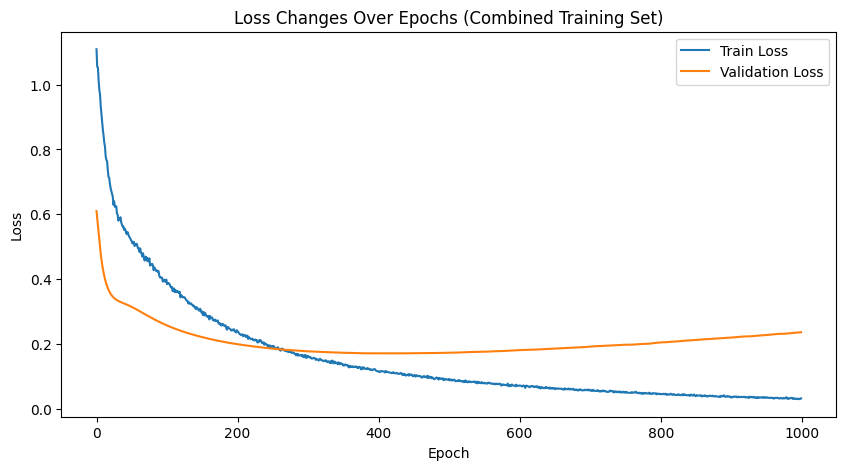

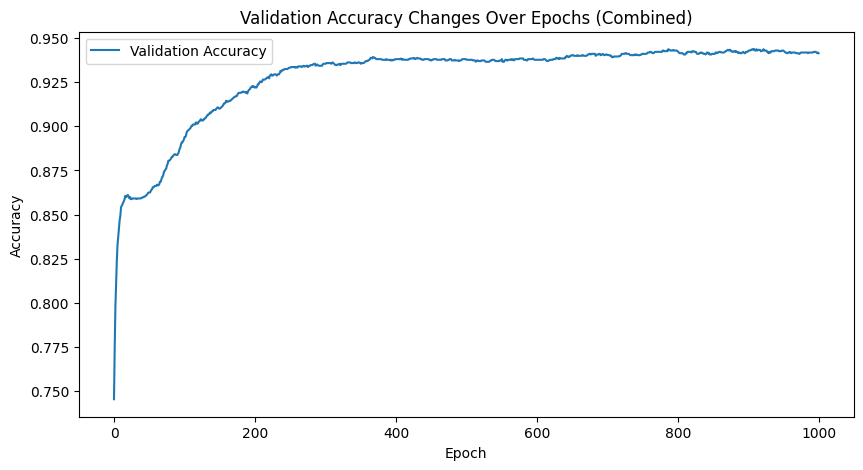

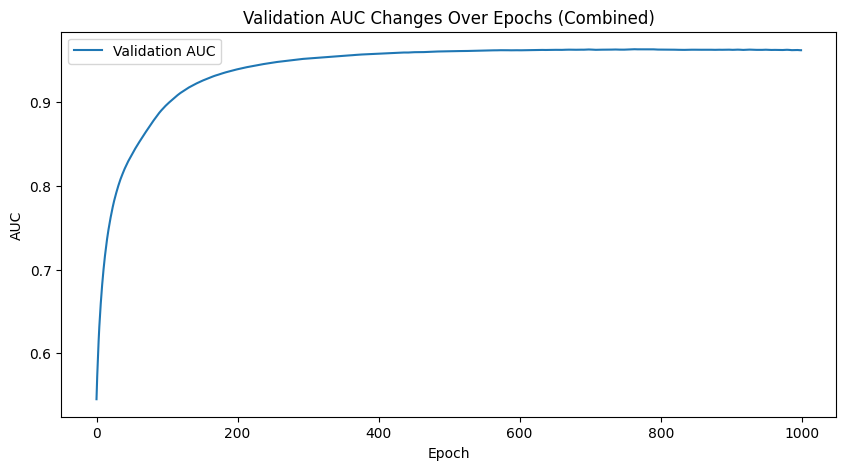

In [81]:
best_val_acc = 0.0
best_state = None

train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

EPOCHS = 1000
for epoch in tqdm(range(EPOCHS), desc="Training on multiple graphs"):
    # 1) Train step (all training graphs)
    train_loss = train_classifier(pre_model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_acc, val_auc = evaluate_classifier(pre_model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    # Track best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = pre_model.state_dict()

# Reload best model
if best_state is not None:
    pre_model.load_state_dict(best_state)

print(f"Best validation accuracy: {best_val_acc:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Changes Over Epochs (Combined Training Set)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Changes Over Epochs (Combined)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC Changes Over Epochs (Combined)')
plt.show()



In [82]:
@torch.no_grad()
def test_on_withheld_graph(model, data):
    model.eval()
    data = data.to(device)
    
    logits = model(data.x, data.edge_index).squeeze()
    labels = data.y.view(-1)
    
    loss = criterion(logits, labels).item()
    probs = torch.sigmoid(logits)
    binary_pred = (probs > 0.5).float()
    
    correct = (binary_pred == labels).sum().item()
    acc = correct / labels.size(0)
    
    try:
        auc = roc_auc_score(labels.cpu(), probs.cpu())
    except ValueError:
        auc = float('nan')
    
    return loss, acc, auc

test_loss, test_acc, test_auc = test_on_withheld_graph(pre_model, test_data)
print(f"\n=== Final Test on '{test_replicate_name}' ===")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")



=== Final Test on '13months-disease-replicate_2' ===
Test Loss: 0.4470 | Test Accuracy: 0.9126 | Test AUC: 0.8332


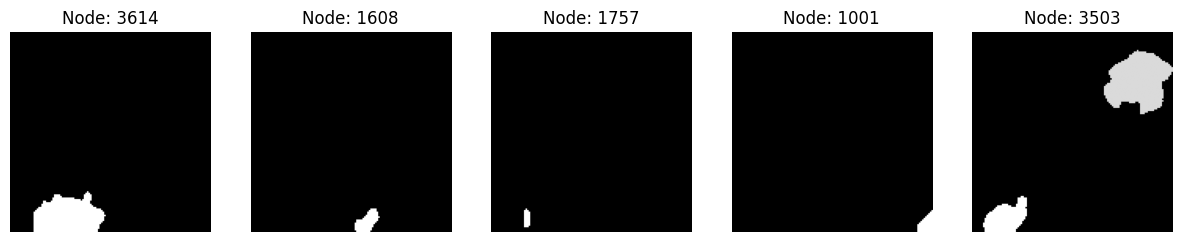

In [83]:
# Get predictions from the classifier
pre_model.eval()
data = graph_data_dict['8months-disease-replicate_1'].clone().to(device)
with torch.no_grad():
    logits = pre_model(data.x, data.edge_index).squeeze()
    preds = (logits.sigmoid() > 0.5).float()

# Identify positive nodes
positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]

# Visualize a subset of the positive nodes' patches images
num_images_to_plot = min(5, len(positive_nodes))  # Plot up to 5 images
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

# Randomly select positive nodes to plot
random_positive_nodes = random.sample(list(positive_nodes), num_images_to_plot)

for i, node in enumerate(random_positive_nodes):
    patch = data.patches[node].squeeze().to("cpu").numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Node: {node.item()}")
plt.show()


In [84]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 76592], edge_attr=[76592, 1], y=[8186, 1], pos=[8186, 2], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 123704], edge_attr=[123704, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 75568], edge_attr=[75568, 1], y=[8202, 1], pos=[8202, 2], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 115726], edge_attr=[115726, 1], y=[9634, 1], pos=[9634, 2], patches=[9634, 128, 128, 1])}

In [85]:
# Store the positive nodes in a dictionary
positive_nodes_dict = {}

for key, data in graph_data_dict.items():
    data = data.clone().to(device)
    with torch.no_grad():
        logits = pre_model(data.x, data.edge_index).squeeze()
        preds = (logits.sigmoid() > 0.5).float()
    positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]
    positive_nodes_dict[key] = positive_nodes

#  Print the number of positive nodes for each replicate
for key, nodes in positive_nodes_dict.items():
    print(f"Number of positive nodes in '{key}': {len(nodes)}")

Number of positive nodes in '8months-disease-replicate_1': 813
Number of positive nodes in '13months-disease-replicate_1': 2245
Number of positive nodes in '8months-disease-replicate_2': 1000
Number of positive nodes in '13months-disease-replicate_2': 828


# Exact values prediction

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training:   0%|          | 12/5000 [00:00<01:29, 55.66it/s]

Epoch 0: Train Loss=4.9287, Val RMSE=2.6621, Val R²=-0.2283


Training:   2%|▏         | 110/5000 [00:01<01:23, 58.63it/s]

Epoch 100: Train Loss=0.7645, Val RMSE=1.4693, Val R²=0.6258


Training:   4%|▍         | 208/5000 [00:03<01:25, 55.77it/s]

Epoch 200: Train Loss=0.6023, Val RMSE=1.4474, Val R²=0.6369


Training:   6%|▌         | 312/5000 [00:05<01:22, 56.66it/s]

Epoch 300: Train Loss=0.4531, Val RMSE=1.4652, Val R²=0.6279


Training:   8%|▊         | 410/5000 [00:07<01:20, 56.92it/s]

Epoch 400: Train Loss=0.4422, Val RMSE=1.4527, Val R²=0.6342


Training:  10%|█         | 509/5000 [00:08<01:18, 57.30it/s]

Epoch 500: Train Loss=0.4124, Val RMSE=1.4665, Val R²=0.6272


Training:  12%|█▏        | 606/5000 [00:10<01:24, 51.85it/s]

Epoch 600: Train Loss=0.3399, Val RMSE=1.4602, Val R²=0.6305


Training:  14%|█▍        | 712/5000 [00:12<01:08, 62.96it/s]

Epoch 700: Train Loss=0.4031, Val RMSE=1.4654, Val R²=0.6278


Training:  15%|█▍        | 746/5000 [00:12<01:13, 57.73it/s]


Early stopping!
Best validation RMSE: 1.4290


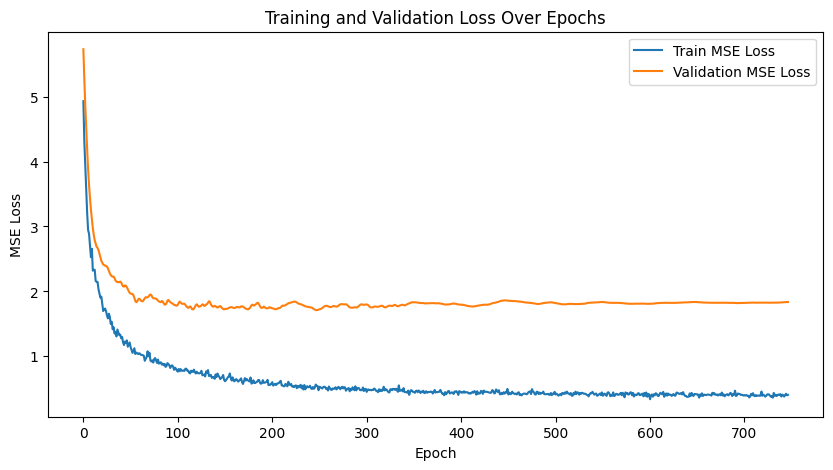

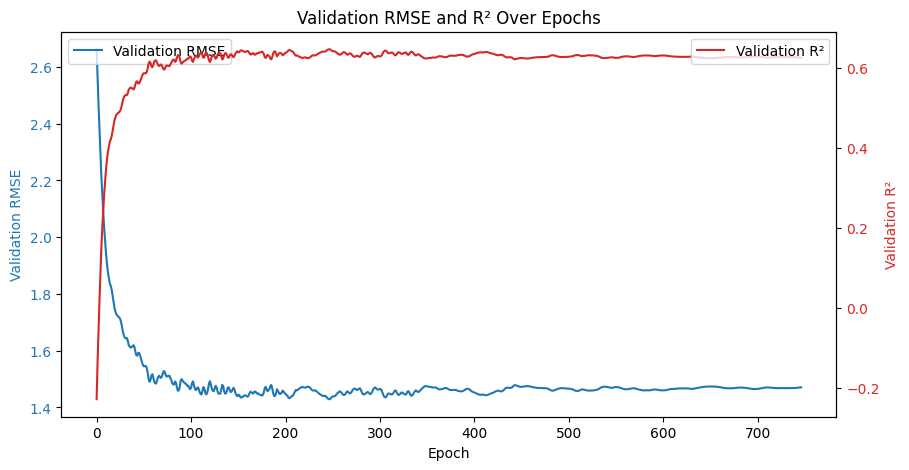

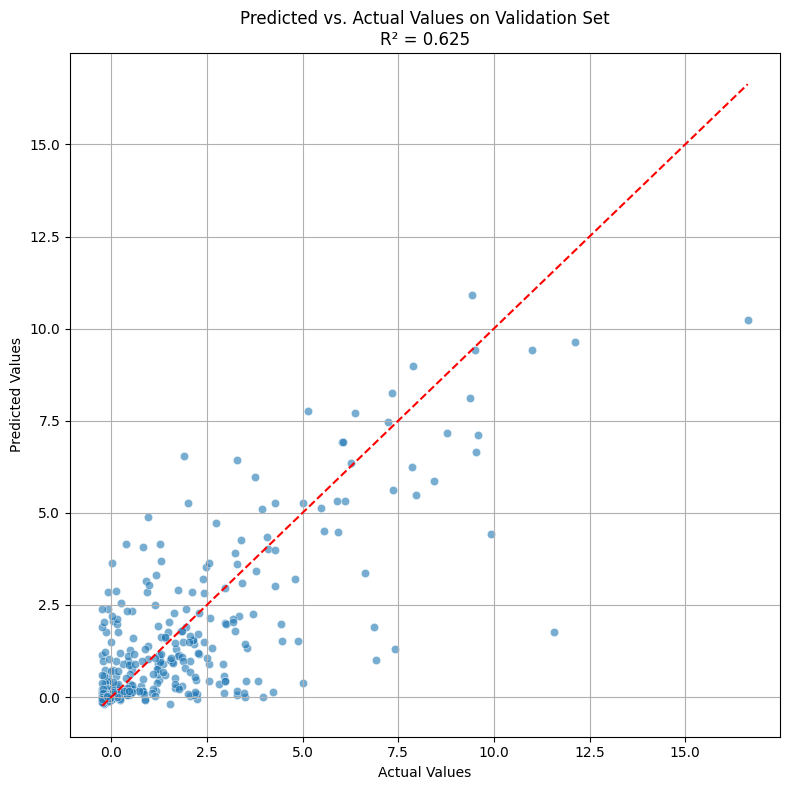


=== Final Test on '13months-disease-replicate_2' ===
Test MSE: 1267073.1250 | Test MAE: 787.1167 | Test RMSE: 1125.6434 | Test R²: -0.7911


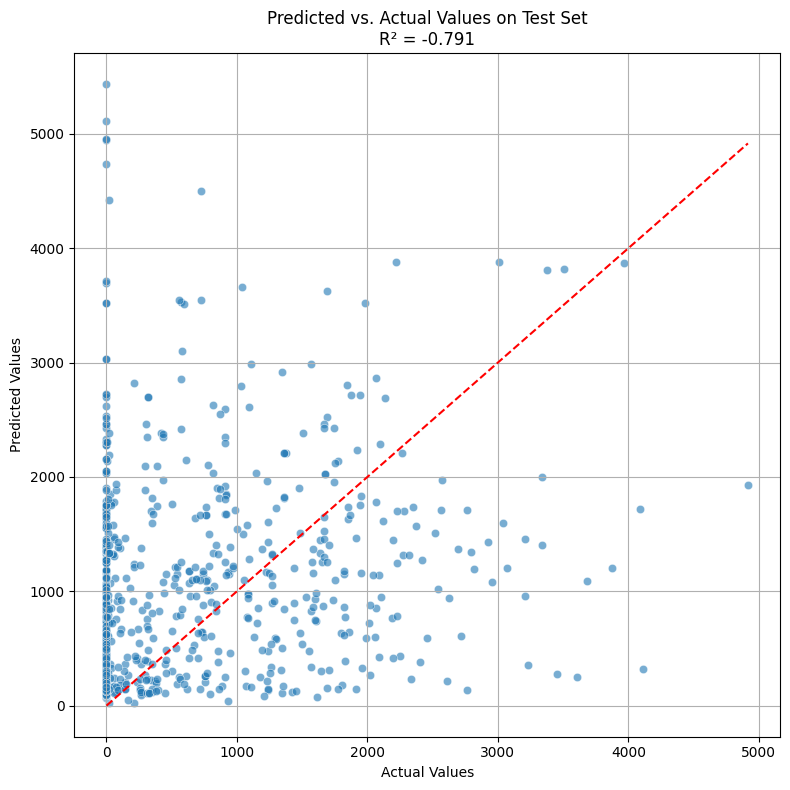

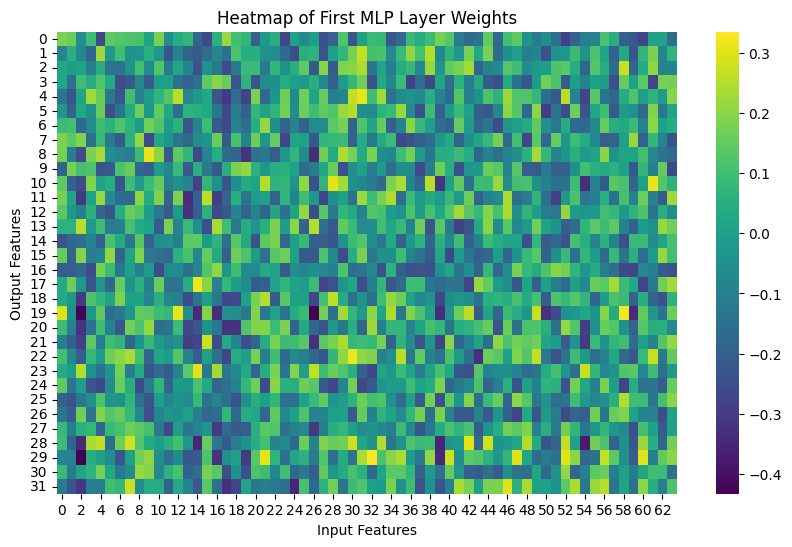


Total number of parameters: 183,617
Trainable parameters: 183,617


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from tqdm import tqdm  # For progress bar

# =====================================
# Step 1: Data Preparation
# =====================================

# Assuming graph_data_dict and positive_nodes_dict are predefined
# Example:
# graph_data_dict = {
#     'graph1': Data(x=..., edge_index=..., y=...),
#     'graph2': Data(x=..., edge_index=..., y=...),
#     ...
# }
# positive_nodes_dict = {
#     'graph1': torch.tensor([...]),
#     'graph2': torch.tensor([...]),
#     ...
# }

test_replicate_name = '13months-disease-replicate_2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Collect all node features and targets for scaling
all_features = []
all_targets = []
all_edge_weights = []  # Collect edge weights for scaling

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    all_features.append(data.x.cpu().numpy())
    all_targets.append(data.y.cpu().numpy())
    
    # Collect edge weights if they exist
    if hasattr(data, 'edge_attr'):
        # If edge_attr exists and represents weights, use it
        all_edge_weights.append(data.edge_attr.cpu().numpy().reshape(-1, 1))

# Fit feature and target scalers
all_features = np.vstack(all_features)
feature_scaler.fit(all_features)

all_targets = np.concatenate(all_targets).reshape(-1, 1)
target_scaler.fit(all_targets)

# Fit edge weight scaler if edge weights exist
if all_edge_weights:
    all_edge_weights = np.vstack(all_edge_weights)
    edge_weight_scaler = StandardScaler()
    edge_weight_scaler.fit(all_edge_weights)

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    
    # Normalize node features
    data.x = torch.tensor(feature_scaler.transform(data.x.cpu()), dtype=torch.float32)
    
    # Normalize target
    data.y = torch.tensor(target_scaler.transform(data.y.cpu().numpy().reshape(-1, 1)).flatten(), dtype=torch.float32)
    
    # Normalize edge weights if they exist
    if hasattr(data, 'edge_attr'):
        # If edge_attr exists and represents weights, normalize them
        data.edge_attr = torch.tensor(
            edge_weight_scaler.transform(data.edge_attr.cpu().numpy().reshape(-1, 1)).flatten(),
            dtype=torch.float32
        )
    
    # Assign default edge weights if none exist
    if not hasattr(data, 'edge_weight') and not hasattr(data, 'edge_attr'):
        data.edge_weight = torch.ones(data.edge_index.size(1), dtype=torch.float32)
    
    if name == test_replicate_name:
        # Assign the entire test graph
        test_data = data.to(device)
        # Assign only positive nodes for testing
        test_data.test_idx = positive_nodes_dict[name].to(device)
    else:
        # Retrieve positive nodes for the current graph
        positive_nodes = positive_nodes_dict[name]
        num_positive = positive_nodes.size(0)
        
        if num_positive == 0:
            print(f"No positive nodes found in '{name}'. Skipping this graph.")
            continue  # Skip graphs with no positive nodes
        
        # Shuffle positive node indices
        perm = torch.randperm(num_positive)
        
        # Split positive nodes into train and validation
        train_cutoff = int(0.8 * num_positive)
        val_cutoff   = int(0.9 * num_positive)
        
        data.train_idx = positive_nodes[perm[:train_cutoff]].to(device)
        data.val_idx   = positive_nodes[perm[train_cutoff:val_cutoff]].to(device)
        # data.mini_test_idx = positive_nodes[perm[val_cutoff:]].to(device)  # Optional
        
        train_val_datalist.append(data.to(device))

test_datalist = [test_data] if test_data is not None else []

# =====================================
# Step 2: Define the Simplified GNN Regressor Model
# =====================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax

class EdgeWeightedAttentionConv(MessagePassing):
    def __init__(self, in_channels, out_channels, dropout=0.3, negative_slope=0.2):
        super(EdgeWeightedAttentionConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.negative_slope = negative_slope

        # Linear transformation for node features
        self.lin = nn.Linear(in_channels, out_channels, bias=False)

        # Attention parameters
        # We'll concatenate source and target node features along with edge_weight
        self.att_src = nn.Parameter(torch.Tensor(1, out_channels))
        self.att_dst = nn.Parameter(torch.Tensor(1, out_channels))
        self.att_edge = nn.Parameter(torch.Tensor(1, 1))  # For edge_weight

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin.weight)
        nn.init.xavier_uniform_(self.att_src)
        nn.init.xavier_uniform_(self.att_dst)
        nn.init.xavier_uniform_(self.att_edge)

    def forward(self, x, edge_index, edge_weight=None):
        """
        Args:
            x (Tensor): Node feature matrix with shape [N, in_channels].
            edge_index (LongTensor): Graph connectivity in COO format with shape [2, E].
            edge_weight (Tensor, optional): Edge weights with shape [E].
        Returns:
            Tensor: Updated node features with shape [N, out_channels].
        """
        # Apply linear transformation
        x = self.lin(x)  # [N, out_channels]

        # If edge_weight is provided, ensure it has shape [E, 1]
        if edge_weight is not None:
            edge_weight = edge_weight.view(-1, 1)  # [E, 1]
        else:
            edge_weight = torch.ones((edge_index.size(1), 1), device=x.device)

        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_i, x_j, edge_weight, index, ptr, size_i):
        """
        Args:
            x_i (Tensor): Target node features for each edge with shape [E, out_channels].
            x_j (Tensor): Source node features for each edge with shape [E, out_channels].
            edge_weight (Tensor): Edge weights with shape [E, 1].
        Returns:
            Tensor: Messages to be aggregated with shape [E, out_channels].
        """
        # Compute attention scores
        # Attention mechanism: a^T [x_i || x_j || edge_weight]
        # where || denotes concatenation

        # Compute individual components
        att_i = (x_i * self.att_src).sum(dim=-1)  # [E]
        att_j = (x_j * self.att_dst).sum(dim=-1)  # [E]
        att_e = (edge_weight * self.att_edge).sum(dim=-1)  # [E]

        # Combine them
        att = att_i + att_j + att_e  # [E]

        # Apply LeakyReLU
        att = F.leaky_relu(att, negative_slope=self.negative_slope)

        # Compute softmax over neighbors
        alpha = softmax(att, index)  # [E]

        # Apply dropout to attention coefficients
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        # Multiply source node features by attention coefficients and edge weights
        # Incorporate edge_weight multiplicatively if desired
        # Here, since edge_weight is already part of attention, it's not multiplied again
        return x_j * alpha.unsqueeze(-1)  # [E, out_channels]

    def update(self, aggr_out):
        # You can apply a non-linearity here if desired
        return aggr_out
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import BatchNorm

class EdgeAttentionGNNRegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, dropout=0.3):
        super(EdgeAttentionGNNRegressor, self).__init__()
        # First custom edge attention layer
        self.conv1 = EdgeWeightedAttentionConv(in_channels, hidden_channels, dropout=dropout)
        self.bn1 = BatchNorm(hidden_channels)
        
        # Second custom edge attention layer
        self.conv2 = EdgeWeightedAttentionConv(hidden_channels, hidden_channels, dropout=dropout)
        self.bn2 = BatchNorm(hidden_channels)
        
        # Fully connected output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None, batch=None):
        """
        Args:
            x (Tensor): Node feature matrix with shape [N, in_channels].
            edge_index (LongTensor): Graph connectivity in COO format with shape [2, E].
            edge_weight (Tensor, optional): Edge weights with shape [E].
            batch (Tensor, optional): Batch vector assigning each node to a specific graph.
        Returns:
            Tensor: Regression output for each node with shape [N].
        """
        # First custom edge attention layer
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second custom edge attention layer
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc(x)
        return x.squeeze()  # Output shape: [N]


class SimplifiedGNNRegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, dropout=0.3):
        super(SimplifiedGNNRegressor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None, batch=None):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc(x)
        return x.squeeze()  # [num_nodes]

# =====================================
# Step 3: Initialize Model, Optimizer, and Loss Function
# =====================================

def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Determine the number of input features
if not train_val_datalist:
    raise ValueError("No training/validation data available. Check positive_nodes_dict and graph_data_dict.")
in_channels = train_val_datalist[0].x.size(1)

# Initialize the model
model = SimplifiedGNNRegressor(
    in_channels=in_channels,
    hidden_channels=64,  # Reduced from 128
    dropout=0.3  # Reduced from 0.6
).to(device)

# Apply weight initialization
model.apply(weights_init)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

# Define the loss function
criterion = nn.MSELoss()

# =====================================
# Step 4: Define Training and Evaluation Functions
# =====================================

@torch.no_grad()
def evaluate_regressor(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Returns average MSE, MAE, RMSE, MAE overall, R², and all labels and predictions.
    """
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    total_nodes = 0
    all_labels = []
    all_preds = []
    
    for data in datalist:
        out = model(data.x, data.edge_index, edge_weight=data.edge_weight).squeeze()
        
        idx = getattr(data, split, None)
        if idx is None or idx.numel() == 0:
            continue
        
        labels = data.y[idx].view(-1)
        preds = out[idx]
        
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        mae = F.l1_loss(preds, labels, reduction='sum').item()
        total_mae += mae
        
        total_nodes += labels.size(0)
        
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
    
    if total_nodes == 0:
        return float('nan'), float('nan'), float('nan'), float('nan'), None, None
    
    avg_loss = total_loss / len(datalist)
    avg_mae = total_mae / total_nodes
    
    all_labels_np = torch.cat(all_labels, dim=0).numpy()
    all_preds_np = torch.cat(all_preds, dim=0).numpy()
    
    rmse = np.sqrt(mean_squared_error(all_labels_np, all_preds_np))
    mae_overall = mean_absolute_error(all_labels_np, all_preds_np)
    r2 = r2_score(all_labels_np, all_preds_np)
    
    return avg_loss, avg_mae, rmse, mae_overall, r2, (all_labels_np, all_preds_np)

def train_regressor(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        out = model(data.x, data.edge_index, edge_weight=data.edge_weight).squeeze()
        
        if data.train_idx.numel() == 0:
            continue  # Skip if there are no training nodes
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Gradient clipping (optional)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    
    return total_loss / len(datalist)

# =====================================
# Step 5: Training Loop with Early Stopping
# =====================================

best_val_rmse = float('inf')
best_state = None
patience = 500
trigger_times = 0

train_losses = []
val_losses = []
val_maes = []
val_rmses = []
val_r2s = []

test_losses = []
test_maes = []
test_rmses = []
test_r2s = []

EPOCHS = 5000
for epoch in tqdm(range(EPOCHS), desc="Training"):
    # 1) Train step (all training graphs)
    train_loss = train_regressor(model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_mae, val_rmse, val_mae_overall, val_r2, _ = evaluate_regressor(model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    # 3) Update scheduler
    scheduler.step(val_loss)

    # 4) Early Stopping Check
    if not np.isnan(val_rmse) and val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping!")
        break

    # Optional: Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val RMSE={val_rmse:.4f}, Val R²={val_r2:.4f}")

# Load Best Model
if best_state:
    model.load_state_dict(best_state)

print(f"Best validation RMSE: {best_val_rmse:.4f}")

# =====================================
# Step 6: Plotting Results
# =====================================

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE Loss')
plt.plot(val_losses, label='Validation MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Plot Validation RMSE and R²
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation RMSE', color=color)
ax1.plot(val_rmses, color=color, label='Validation RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation R²', color=color)
ax2.plot(val_r2s, color=color, label='Validation R²')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Validation RMSE and R² Over Epochs')
plt.show()

# Scatter Plot: Predicted vs. Actual on Validation Set
_, _, _, _, val_r2, (val_labels, val_preds) = evaluate_regressor(
    model, 
    train_val_datalist, 
    split="val_idx"
)

if val_labels is not None and val_preds is not None:
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=val_labels, y=val_preds, alpha=0.6)
    plt.plot([val_labels.min(), val_labels.max()], [val_labels.min(), val_labels.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs. Actual Values on Validation Set\nR² = {val_r2:.3f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No positive nodes available in the validation split for plotting.")

# =====================================
# Step 7: Final Testing on Withheld Graph
# =====================================

@torch.no_grad()
def test_on_withheld_graph_regression(model, data):
    model.eval()
    out = model(data.x, data.edge_index, edge_weight=data.edge_weight).squeeze()
    
    idx = data.test_idx  # Use only positive nodes for testing
    if idx.numel() == 0:
        print("No positive nodes in the test graph.")
        return float('nan'), float('nan'), float('nan'), float('nan')
    
    labels = data.y[idx].view(-1)
    preds  = out[idx]
    
    # Inverse transform to original scale
    labels = target_scaler.inverse_transform(labels.cpu().numpy().reshape(-1, 1)).flatten()
    preds = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).flatten()
    
    loss = mean_squared_error(labels, preds)
    mae = mean_absolute_error(labels, preds)
    rmse = np.sqrt(loss)
    r2 = r2_score(labels, preds)
    
    return loss, mae, rmse, r2

if test_data is not None:
    test_loss, test_mae, test_rmse, test_r2 = test_on_withheld_graph_regression(model, test_data)
    print(f"\n=== Final Test on '{test_replicate_name}' ===")
    print(f"Test MSE: {test_loss:.4f} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f} | Test R²: {test_r2:.4f}")
else:
    print("No test data available.")

# Optional: Scatter Plot for Test Set
if test_data is not None:
    with torch.no_grad():
        out = model(test_data.x, test_data.edge_index, edge_weight=test_data.edge_weight).squeeze()
        idx = test_data.test_idx
        labels = test_data.y[idx].view(-1)
        preds = out[idx]
        
        # Inverse transform to original scale
        labels = target_scaler.inverse_transform(labels.cpu().numpy().reshape(-1, 1)).flatten()
        preds = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).flatten()
        
        if len(labels) > 0:
            test_r2 = r2_score(labels, preds)
            plt.figure(figsize=(8, 8))
            sns.scatterplot(x=labels, y=preds, alpha=0.6)
            plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title(f'Predicted vs. Actual Values on Test Set\nR² = {test_r2:.3f}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("No positive nodes available in the test split for plotting.")

# =====================================
# Step 8: (Optional) Visualize Model Parameters
# =====================================

# Visualize weights of the first linear layer in the MLP
mlp_weights = model.fc[0].weight.detach().cpu().numpy()

plt.figure(figsize=(10, 6))
sns.heatmap(mlp_weights, cmap='viridis')
plt.xlabel('Input Features')
plt.ylabel('Output Features')
plt.title('Heatmap of First MLP Layer Weights')
plt.show()

# Optional: Print model parameter statistics
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal number of parameters: {total_params:,}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")
